# Distancia productos clientes

> Agregar bloque entrecomillado


Voy a ver de agrupar productos


*  En función de fechas inicio / fin
*  En función de distancia vectorial



## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend



#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.7 MB/s eta 0:00:00


In [4]:
from dtaidistance import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import time

In [5]:

# ventas al canal, va a ser el archivo padre
#sellin = pd.read_csv(DATOS_DIR +'sell-in.txt', sep='\t')
full_product = pd.read_csv(DATOS_DIR +'df_base_6.csv')
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665


## ahora vamos a dejarla solamente como sumarizado por producto por espacio de venta

Vemos que tenemos un cluster muy grande de 560 productos y luego todos clusters chicos de productos con mucho menos cantidad de tiempo

### matriz ancha producto cliente

In [6]:
# vamos a hacer la matriz ancha producto cliente, tantas filas como combinaciones, 36 columnas, solamente los valores que existan
df_prod_cliente= full_product.copy()

In [7]:
df_prod_cliente['cust_prod_id']= df_prod_cliente['product_id'].astype(str) + '_' + df_prod_cliente['customer_id'].astype(str)
df_prod_cliente.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,20524_10234
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,20524_10032
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,20524_10217
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,20524_10125
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,20524_10012


In [8]:
# voy a hacer lo mismo y ver cómo se distribuyen en el tiempo
g1 = df_prod_cliente.groupby('cust_prod_id')['date_mes']
resumen_xy = g1.agg(primer_mes_venta='min', ultima_mes_venta='max').reset_index()

In [9]:
resumen_xy.head()

,cust_prod_id,primer_mes_venta,ultima_mes_venta
0,20001_10001,2017-01,2019-12
1,20001_10002,2017-01,2019-12
2,20001_10003,2017-01,2019-12
3,20001_10004,2017-01,2019-12
4,20001_10005,2017-01,2019-12


In [10]:
resumen_xy['primer_mes_venta'] = pd.to_datetime(resumen_xy['primer_mes_venta'])
resumen_xy['ultima_mes_venta'] = pd.to_datetime(resumen_xy['ultima_mes_venta'])

resumen_xy['periodo_venta'] = (
    resumen_xy['primer_mes_venta'].dt.strftime('%Y-%m') +
    ' → ' +
    resumen_xy['ultima_mes_venta'].dt.strftime('%Y-%m')
)

In [11]:
conteo = resumen_xy['periodo_venta'].value_counts().sort_index()
#print(conteo)

In [12]:
print(conteo.sort_values(ascending=False).head(10))

periodo_venta
2017-01 → 2019-12    19830
2017-01 → 2019-11    12213
2017-02 → 2019-12     6697
2017-01 → 2019-10     5989
2017-02 → 2019-11     5682
2017-01 → 2019-09     4029
2017-03 → 2019-12     3966
2017-03 → 2019-11     3747
2017-02 → 2019-10     3464
2019-10 → 2019-10     3326
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

conteo.plot(kind='barh', figsize=(10,5))
plt.xlabel('Cantidad de productos')
plt.ylabel('Primer venta → Última venta')
plt.title('Cantidad de productos por ventana de ventas')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [13]:
# Unimos el periodo_venta a la tabla original por producto
full_prod_cust = df_prod_cliente.merge(resumen_xy[['cust_prod_id', 'periodo_venta']], on='cust_prod_id', how='left')
full_prod_cust.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,cust_prod_id,periodo_venta
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,20524_10234,2017-01 → 2019-10
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,20524_10032,2017-01 → 2019-11
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,20524_10217,2017-01 → 2019-10
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,20524_10125,2017-01 → 2019-10
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,20524_10012,2017-01 → 2019-12


In [14]:
# guardar archivo
full_prod_cust.to_parquet(DATOS_DIR +'full_prod_cust.parquet', index=False)

# Si fuera necesario, instala pyarrow:
#!pip install pyarrow




In [15]:
# voy a generar los dos df de product_id clusterizados por período de ventas
periodo_objetivo = "2017-01 → 2019-12"
periodo_objetivo1 = "2017-01 → 2019-11"
condicion_corta= (full_prod_cust['periodo_venta'] != periodo_objetivo) & (full_prod_cust['periodo_venta'] != periodo_objetivo1)

cust_product_ids_ventas_largo = full_prod_cust.loc[full_prod_cust['periodo_venta'] == periodo_objetivo, ['cust_prod_id']].drop_duplicates().reset_index(drop=True)
cust_product_ids_ventas_2 = full_prod_cust.loc[full_prod_cust['periodo_venta'] == periodo_objetivo1, ['cust_prod_id']].drop_duplicates().reset_index(drop=True)
cus_product_ids_ventas_corto = full_prod_cust.loc[(full_prod_cust['periodo_venta'] != periodo_objetivo) & (full_prod_cust['periodo_venta'] != periodo_objetivo1), ['cust_prod_id']].drop_duplicates().reset_index(drop=True)
#cus_product_ids_ventas_corto = full_prod_cust.loc[(full_prod_cust['periodo_venta'] != periodo_objetivo) , ['product_id']].drop_duplicates().reset_index(drop=True)
#cus_product_ids_ventas_corto = cus_product_ids_ventas_corto.loc[cus_product_ids_ventas_corto['periodo_venta'] != periodo_objetivo1, ['product_id']].drop_duplicates().reset_index(drop=True)
#print(product_ids_ventas_corto.head(), product_ids_ventas_corto.shape)
#print(product_ids_ventas_largo.head(), product_ids_ventas_largo.shape)
cust_product_ids_ventas_largo.to_csv(DATOS_DIR +'cust_product_ids_ventas_largo.csv', index=False)
cust_product_ids_ventas_2.to_csv(DATOS_DIR +'cust_product_ids_ventas_2.csv', index=False)
cus_product_ids_ventas_corto.to_csv(DATOS_DIR +'cus_product_ids_ventas_corto.csv', index=False)

### me queda un cluster que inicia y finaliza en diciembre, otro que finaliza an noviembre y el resot

In [ ]:
cust_product_ids_ventas_2.head()

,cust_prod_id
0,20524_10032
1,20524_10011
2,20524_10040
3,20524_10037
4,20524_10045


### voy a matriz ancha para procesar

In [16]:
df_ancho_prod_cliente = df_prod_cliente.pivot_table(
    index='cust_prod_id',  # <-- Usamos la nueva columna aquí
    columns='date',
    values='tn',
    aggfunc='sum'          # 'sum' sigue siendo importante por si hay duplicados
)

# Limpiamos el nombre del eje de las columnas que `pivot_table` añade
df_ancho_prod_cliente.columns.name = None

# Movemos el índice 'cust_prod_id' para que sea una columna regular del DataFrame.
# Esto es opcional, pero coincide con el formato final del ejemplo anterior.
df_ancho_prod_cliente = df_ancho_prod_cliente.reset_index()

print("\n--- Matriz Ancha Final con Índice Concatenado ---")
print(df_ancho_prod_cliente.head())


--- Matriz Ancha Final con Índice Concatenado ---
  cust_prod_id  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  \
0  20001_10001      99.439     198.844      92.465      13.297     101.006   
1  20001_10002      35.728       6.794      29.941      22.811      31.228   
2  20001_10003     143.494      20.483     137.875      68.893     135.122   
3  20001_10004     184.729     104.039     295.439     247.656     188.378   
4  20001_10005      19.084       5.171       5.171       0.862      37.955   

   2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  \
0     128.048     101.207      43.339     289.350     222.114     111.549   
1      47.570      21.849      17.081      59.177       3.313      48.813   
2     171.018      64.662      83.634      70.617      62.233     125.765   
3     195.027     379.443     237.168     141.726     437.378     183.509   
4      19.084      43.350      67.539       6.223       6.156      32.504   

   2017-12-01  20

In [17]:
df_ancho_prod_cliente.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219
1,20001_10002,35.728,6.794,29.941,22.811,31.228,47.570,21.849,17.081,59.177,3.313,48.813,41.537,44.705,8.536,40.384,47.631,39.476,0.762,32.968,55.842,17.274,19.783,26.885,131.289,9.779,6.486,31.971,55.417,30.873,144.070,37.146,NaN,72.086,17.408,45.615,113.332
2,20001_10003,143.494,20.483,137.875,68.893,135.122,171.018,64.662,83.634,70.617,62.233,125.765,134.495,42.500,77.451,190.581,187.490,27.972,168.502,141.875,275.572,3.327,67.392,200.495,98.915,180.511,81.215,170.899,230.002,1.848,NaN,138.234,162.072,233.205,76.006,86.144,102.275
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648
4,20001_10005,19.084,5.171,5.171,0.862,37.955,19.084,43.350,67.539,6.223,6.156,32.504,30.781,4.432,12.197,36.720,4.559,15.033,29.574,24.029,32.262,15.324,34.469,15.649,19.357,6.531,4.559,6.900,22.180,15.896,NaN,8.256,NaN,12.804,17.139,12.221,19.604


## ahora vamos a clusterizar por similitud

In [19]:
total_filas = len(df_ancho_prod_cliente)
sin_nan = (df_ancho_prod_cliente.isna().sum(axis=1) == 0).sum()
con_nan = total_filas - sin_nan

print(f"Total filas: {total_filas}")
print(f"Filas sin NaN: {sin_nan}")
print(f"Filas con al menos un NaN: {con_nan}")

Total filas: 374439
Filas sin NaN: 1696
Filas con al menos un NaN: 372743


In [20]:
# OJO esto quiere decir que tengo algunos NaN que en realidad son ceros
def nan_interno_a_cero(row):
    # The row is already a Series, select only numerical values
    x = row.values.copy()

    # Find the first non-NaN value (start of the series)
    # Check if there are any non-NaN values before proceeding
    if np.any(~np.isnan(x)):
        first_idx = np.argmax(~np.isnan(x))
        # Find the last non-zero and non-NaN value
        def is_real(v):
            return not np.isnan(v) and v != 0
        real_idxs = [i for i, v in enumerate(x) if is_real(v)]
        last_idx = max(real_idxs) if real_idxs else first_idx # Use first_idx if no real values found after it


        # Only process if there is a valid range
        if first_idx != -1 and last_idx != -1:
            for i in range(first_idx, last_idx + 1):
                if np.isnan(x[i]):
                    x[i] = 0 # replace internal NaN with zero

        return pd.Series(x, index=row.index) # Return a Series with the same index
    else:
        return row # return the original row if no numerical values or all are NaN


# Select only the numerical columns before applying the function
numerical_df = df_ancho_prod_cliente.select_dtypes(include=np.number)

# Apply the function to the numerical columns
df_corr_cli_prod_numerical = numerical_df.apply(nan_interno_a_cero, axis=1)

# Combine the 'cust_prod_id' column with the processed numerical columns
df_corr_cli_prod = pd.concat([df_ancho_prod_cliente['cust_prod_id'], df_corr_cli_prod_numerical], axis=1)


total_filas = len(df_corr_cli_prod)
sin_nan = (df_corr_cli_prod.isna().sum(axis=1) == 0).sum()
con_nan = total_filas - sin_nan

print(f"Total filas: {total_filas}")
print(f"Filas sin NaN: {sin_nan}")
print(f"Filas con al menos un NaN: {con_nan}")

Total filas: 374439
Filas sin NaN: 19830
Filas con al menos un NaN: 354609


In [24]:
df_corr_cli_prod.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,20001_10001,99.439,198.844,92.465,13.297,101.006,128.048,101.207,43.339,289.350,222.114,111.549,131.272,49.619,88.441,214.723,132.834,165.735,92.294,256.058,139.242,358.579,245.214,241.024,254.624,386.607,309.906,130.549,364.371,439.906,65.924,144.787,33.640,109.052,176.030,236.656,180.219
1,20001_10002,35.728,6.794,29.941,22.811,31.228,47.570,21.849,17.081,59.177,3.313,48.813,41.537,44.705,8.536,40.384,47.631,39.476,0.762,32.968,55.842,17.274,19.783,26.885,131.289,9.779,6.486,31.971,55.417,30.873,144.070,37.146,0.000,72.086,17.408,45.615,113.332
2,20001_10003,143.494,20.483,137.875,68.893,135.122,171.018,64.662,83.634,70.617,62.233,125.765,134.495,42.500,77.451,190.581,187.490,27.972,168.502,141.875,275.572,3.327,67.392,200.495,98.915,180.511,81.215,170.899,230.002,1.848,0.000,138.234,162.072,233.205,76.006,86.144,102.275
3,20001_10004,184.729,104.039,295.439,247.656,188.378,195.027,379.443,237.168,141.726,437.378,183.509,86.354,414.051,139.175,288.320,173.834,228.993,240.375,152.550,384.826,191.074,469.458,96.114,236.790,70.237,155.261,102.645,91.678,389.027,66.720,228.624,96.114,288.342,324.962,195.678,34.648
4,20001_10005,19.084,5.171,5.171,0.862,37.955,19.084,43.350,67.539,6.223,6.156,32.504,30.781,4.432,12.197,36.720,4.559,15.033,29.574,24.029,32.262,15.324,34.469,15.649,19.357,6.531,4.559,6.900,22.180,15.896,0.000,8.256,0.000,12.804,17.139,12.221,19.604


In [27]:
# 1. Serie con los product_id (strings)
productos_cliente = df_corr_cli_prod.iloc[:, 0]  # o df['product_id'] si sabes el nombre
# productos ahora es una Serie de los IDs de producto
productos_cliente.head()

,cust_prod_id
0,20001_10001
1,20001_10002
2,20001_10003
3,20001_10004
4,20001_10005


In [29]:
# 2. Calcular el desvío estándar (std) por fila, solo sobre los datos de ventas
desvios_pc = df_corr_cli_prod.iloc[:, 1:].std(axis=1)

# 3. Normalizar cada fila (ventas / std), sin modificar la columna de los IDs
ventas_normalizadas = df_corr_cli_prod.iloc[:, 1:].div(desvios_pc, axis=0)
ventas_normalizadas.head()

,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,0.938,1.875,0.872,0.125,0.953,1.208,0.954,0.409,2.729,2.095,1.052,1.238,0.468,0.834,2.025,1.253,1.563,0.870,2.415,1.313,3.382,2.313,2.273,2.401,3.646,2.923,1.231,3.436,4.149,0.622,1.365,0.317,1.028,1.660,2.232,1.700
1,1.079,0.205,0.904,0.689,0.943,1.436,0.660,0.516,1.787,0.100,1.474,1.254,1.350,0.258,1.219,1.438,1.192,0.023,0.995,1.686,0.522,0.597,0.812,3.964,0.295,0.196,0.965,1.673,0.932,4.350,1.122,0.000,2.176,0.526,1.377,3.422
2,2.067,0.295,1.986,0.993,1.947,2.464,0.932,1.205,1.017,0.897,1.812,1.938,0.612,1.116,2.746,2.701,0.403,2.428,2.044,3.970,0.048,0.971,2.889,1.425,2.601,1.170,2.462,3.314,0.027,0.000,1.992,2.335,3.360,1.095,1.241,1.473
3,1.617,0.910,2.585,2.167,1.648,1.707,3.320,2.075,1.240,3.827,1.606,0.756,3.623,1.218,2.523,1.521,2.004,2.104,1.335,3.368,1.672,4.108,0.841,2.072,0.615,1.359,0.898,0.802,3.404,0.584,2.001,0.841,2.523,2.844,1.712,0.303
4,1.308,0.354,0.354,0.059,2.601,1.308,2.971,4.628,0.426,0.422,2.227,2.109,0.304,0.836,2.516,0.312,1.030,2.027,1.647,2.211,1.050,2.362,1.072,1.326,0.448,0.312,0.473,1.520,1.089,0.000,0.566,0.000,0.877,1.174,0.837,1.343


In [32]:
# 4. Guardar un DataFrame con los product_id y los desvíos usados
df_desvios_pc = pd.DataFrame({
    'product_cust_id': productos_cliente,
    'std_ventas': desvios_pc
})
df_desvios_pc.head()

,product_cust_id,std_ventas
0,20001_10001,106.033
1,20001_10002,33.122
2,20001_10003,69.411
3,20001_10004,114.273
4,20001_10005,14.593


In [35]:
#normailizo y guardo

ventas_normalizadas.to_parquet(DATOS_DIR +'df_norm_pc.parquet', index=False)
df_desvios_pc.to_csv(DATOS_DIR +'desvios_df_pc.csv', index=False)



In [39]:
# Si quieres mantener los IDs a la izquierda:
df_normalizado1 = pd.concat([productos_cliente, ventas_normalizadas], axis=1)
df_normalizado1.head()

,cust_prod_id,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,20001_10001,0.938,1.875,0.872,0.125,0.953,1.208,0.954,0.409,2.729,2.095,1.052,1.238,0.468,0.834,2.025,1.253,1.563,0.870,2.415,1.313,3.382,2.313,2.273,2.401,3.646,2.923,1.231,3.436,4.149,0.622,1.365,0.317,1.028,1.660,2.232,1.700
1,20001_10002,1.079,0.205,0.904,0.689,0.943,1.436,0.660,0.516,1.787,0.100,1.474,1.254,1.350,0.258,1.219,1.438,1.192,0.023,0.995,1.686,0.522,0.597,0.812,3.964,0.295,0.196,0.965,1.673,0.932,4.350,1.122,0.000,2.176,0.526,1.377,3.422
2,20001_10003,2.067,0.295,1.986,0.993,1.947,2.464,0.932,1.205,1.017,0.897,1.812,1.938,0.612,1.116,2.746,2.701,0.403,2.428,2.044,3.970,0.048,0.971,2.889,1.425,2.601,1.170,2.462,3.314,0.027,0.000,1.992,2.335,3.360,1.095,1.241,1.473
3,20001_10004,1.617,0.910,2.585,2.167,1.648,1.707,3.320,2.075,1.240,3.827,1.606,0.756,3.623,1.218,2.523,1.521,2.004,2.104,1.335,3.368,1.672,4.108,0.841,2.072,0.615,1.359,0.898,0.802,3.404,0.584,2.001,0.841,2.523,2.844,1.712,0.303
4,20001_10005,1.308,0.354,0.354,0.059,2.601,1.308,2.971,4.628,0.426,0.422,2.227,2.109,0.304,0.836,2.516,0.312,1.030,2.027,1.647,2.211,1.050,2.362,1.072,1.326,0.448,0.312,0.473,1.520,1.089,0.000,0.566,0.000,0.877,1.174,0.837,1.343


In [36]:
# genero cluster jerárquicos
# OJO voy a meter 0 en los NaN esto es algo a revisar luego
df_dtw_dist_pc = ventas_normalizadas
#df_dtw_dist = df_dtw_dist.fillna(0)
df_dtw_dist_pc.head()

,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,0.938,1.875,0.872,0.125,0.953,1.208,0.954,0.409,2.729,2.095,1.052,1.238,0.468,0.834,2.025,1.253,1.563,0.870,2.415,1.313,3.382,2.313,2.273,2.401,3.646,2.923,1.231,3.436,4.149,0.622,1.365,0.317,1.028,1.660,2.232,1.700
1,1.079,0.205,0.904,0.689,0.943,1.436,0.660,0.516,1.787,0.100,1.474,1.254,1.350,0.258,1.219,1.438,1.192,0.023,0.995,1.686,0.522,0.597,0.812,3.964,0.295,0.196,0.965,1.673,0.932,4.350,1.122,0.000,2.176,0.526,1.377,3.422
2,2.067,0.295,1.986,0.993,1.947,2.464,0.932,1.205,1.017,0.897,1.812,1.938,0.612,1.116,2.746,2.701,0.403,2.428,2.044,3.970,0.048,0.971,2.889,1.425,2.601,1.170,2.462,3.314,0.027,0.000,1.992,2.335,3.360,1.095,1.241,1.473
3,1.617,0.910,2.585,2.167,1.648,1.707,3.320,2.075,1.240,3.827,1.606,0.756,3.623,1.218,2.523,1.521,2.004,2.104,1.335,3.368,1.672,4.108,0.841,2.072,0.615,1.359,0.898,0.802,3.404,0.584,2.001,0.841,2.523,2.844,1.712,0.303
4,1.308,0.354,0.354,0.059,2.601,1.308,2.971,4.628,0.426,0.422,2.227,2.109,0.304,0.836,2.516,0.312,1.030,2.027,1.647,2.211,1.050,2.362,1.072,1.326,0.448,0.312,0.473,1.520,1.089,0.000,0.566,0.000,0.877,1.174,0.837,1.343


In [37]:
## vamos a ver now dice que puede tomar series cortas, veremos
print("\nCreando la lista de series con su longitud real...")
# Changed dtype to np.double to match expected 'seq_t' type in dtaidistance C code
# Filter out empty series before creating the list
series_list_pc = [row.dropna().to_numpy(dtype=np.double) for index, row in df_dtw_dist_pc.iterrows() if not row.dropna().empty]


# Verificamos que se haya creado correctamente
print(f"Tipo de dato creado: {type(series_list_pc)}")
print(f"Número de series en la lista: {len(series_list_pc)}")
print(f"Tipo de dato del primer elemento de la lista: {type(series_list_pc[0])}")
print(f"Longitud de la primera serie: {len(series_list_pc[0])}")
if len(series_list_pc) > 0:
    print(f"Longitud de la última serie (la corta): {len(series_list_pc[-1])}")
else:
    print("No series were created (all were empty).")


Creando la lista de series con su longitud real...
Tipo de dato creado: <class 'list'>
Número de series en la lista: 302872
Tipo de dato del primer elemento de la lista: <class 'numpy.ndarray'>
Longitud de la primera serie: 36
Longitud de la última serie (la corta): 2


In [3]:
series_list_pc

NameError: name 'series_list_pc' is not defined

In [42]:
series_list = []
product_ids_list = [] # <-- La lista para guardar los IDs en el orden correcto

for cost_prod_id, row in df_normalizado1.iterrows():
    cleaned_series = row.dropna()
    if not cleaned_series.empty:
        series_list.append(cleaned_series.to_numpy(dtype=np.double))
        product_ids_list.append(cost_prod_id)

print(f"\nSe procesaron {len(series_list)} series válidas.")
print(f"IDs de productos correspondientes: {product_ids_list}")

Output hidden; open in https://colab.research.google.com to view.

In [2]:
# Esta es la parte computacionalmente más intensiva.
# dtaidistance usará todos los cores de CPU disponibles.
print("\nPaso 3: Calculando la matriz de distancias DTW...")
start_time = time.time()

# La función dtw.distance_matrix_fast es la clave.
# Utiliza una implementación en C con paralelización (OpenMP).
# `use_mp=True` activa el uso de múltiples procesadores.
ds = dtw.distance_matrix_fast(series_list, use_mp=True)

end_time = time.time()
print(f"Cálculo de la matriz de distancias finalizado en {end_time - start_time:.2f} segundos.")
print(f"Dimensiones de la matriz de distancias: {ds.shape}")


Paso 3: Calculando la matriz de distancias DTW...


NameError: name 'time' is not defined

In [ ]:
# ==============================================================================
# 4.5. ¡NUEVO! GUARDAR LA MATRIZ DE DISTANCIAS
# ==============================================================================
print("\nPaso 4.5: Guardando la matriz de distancias en un archivo...")

# Definimos el nombre del archivo
file_path = DATOS_DIR +'dtw_distance_matrix.npy'

# Usamos np.save para guardar el array en formato binario de NumPy
np.save(file_path, ds)

print(f"Matriz guardada exitosamente en '{file_path}'.")
# Comprobamos el tamaño del archivo
#file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
#print(f"Tamaño del archivo: {file_size_mb:.2f} MB")


Paso 4.5: Guardando la matriz de distancias en un archivo...
Matriz guardada exitosamente en '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/dtw_distance_matrix.npy'.


In [ ]:
# La función `linkage` de Scipy no trabaja con la matriz cuadrada completa,
# sino con una forma "condensada" (un vector con las distancias del triángulo superior).
# `squareform` hace esta conversión por nosotros. Es un paso obligatorio.
condensed_ds = squareform(ds)

print(f"Dimensiones de la matriz de distancias original: {ds.shape}")
print(f"Dimensiones de la matriz de distancias condensada: {condensed_ds.shape}")

Dimensiones de la matriz de distancias original: (1213, 1213)
Dimensiones de la matriz de distancias condensada: (735078,)


In [ ]:
# `linkage` es la función que realiza el clustering.
# Parámetros clave:
#   - condensed_ds: Tu matriz de distancias ya preparada.
#   - method='ward': El método de enlace. 'ward' es una excelente opción por defecto.
#     Busca minimizar la varianza dentro de cada cluster. Otras opciones comunes
#     son 'average', 'complete', 'single'.
model = linkage(condensed_ds, method='ward')

print("\nModelo de clustering jerárquico creado.")


Modelo de clustering jerárquico creado.


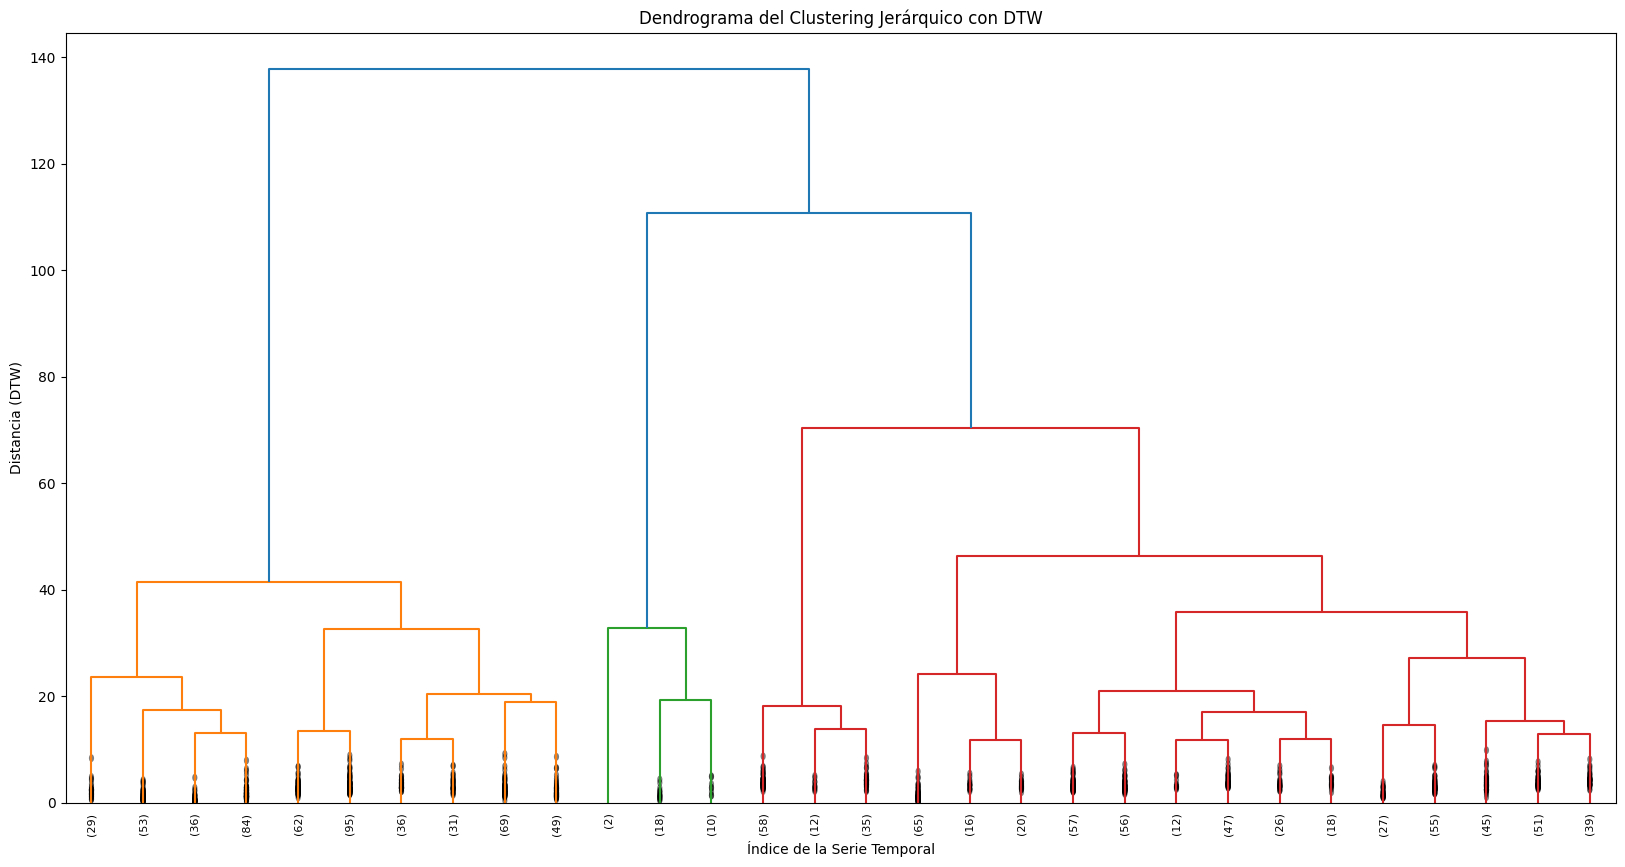

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Dendrograma del Clustering Jerárquico con DTW')
plt.xlabel('Índice de la Serie Temporal')
plt.ylabel('Distancia (DTW)')

# `dendrogram` dibuja el árbol.
# Para datasets grandes (como el tuyo de 1250 series), es imposible etiquetar todo.
# `truncate_mode='lastp'` y `p=30` son tus mejores amigos aquí:
# Muestran los últimos 30 clusters fusionados, que es la parte más importante.
dendrogram(
    model,
    truncate_mode='lastp',  # Muestra solo los últimos 'p' clusters fusionados
    p=30,                   # El número de clusters finales a mostrar
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,   # Para representar el tamaño de los clusters no mostrados
)
plt.show()

In [ ]:
# ==============================================================================
# 4. EXTRAER LOS CLUSTERS
# ==============================================================================


# Una vez que has visto el dendrograma, puedes "cortarlo" a una altura
# determinada o especificar el número de clusters que quieres.

# Opción A: Especificar el número de clusters (la más común)
# Mirando el dendrograma, decides que quieres, por ejemplo, 5 clusters.
num_clusters = 5
clusters = fcluster(model, t=num_clusters, criterion='maxclust')

# Opción B: Cortar por distancia (útil si tienes una idea de la escala de distancia)
# max_distancia = 20  # Por ejemplo, todos los clusters por debajo de esta distancia se fusionan
# clusters = fcluster(model, t=max_distancia, criterion='distance')

print(f"\nAsignación de clusters para las primeras 20 series (para {num_clusters} clusters):")
# `clusters` es un array donde el valor en la posición `i` es el ID del cluster
# al que pertenece la serie `i`.
for i in range(20):
    print(f"Serie {i} -> Cluster {clusters[i]}")

# Ahora puedes, por ejemplo, añadir esta información a un DataFrame para análisis posterior

df_resultados = pd.DataFrame({
    'product_id': product_ids_list,
    'cluster_id': clusters
})

# Opcional: Establecer 'product_id' como el índice del nuevo DataFrame
df_resultados.set_index('product_id', inplace=True)


print("\nDataFrame de Resultados (product_id -> cluster_id):")
print(df_resultados)

# Puedes verificar la distribución de productos por cluster
print("\nConteo de productos por cluster:")
print(df_resultados['cluster_id'].value_counts())


Asignación de clusters para las primeras 20 series (para 5 clusters):
Serie 0 -> Cluster 3
Serie 1 -> Cluster 4
Serie 2 -> Cluster 5
Serie 3 -> Cluster 5
Serie 4 -> Cluster 5
Serie 5 -> Cluster 3
Serie 6 -> Cluster 5
Serie 7 -> Cluster 5
Serie 8 -> Cluster 3
Serie 9 -> Cluster 1
Serie 10 -> Cluster 5
Serie 11 -> Cluster 5
Serie 12 -> Cluster 3
Serie 13 -> Cluster 5
Serie 14 -> Cluster 3
Serie 15 -> Cluster 5
Serie 16 -> Cluster 5
Serie 17 -> Cluster 5
Serie 18 -> Cluster 5
Serie 19 -> Cluster 5

DataFrame de Resultados (product_id -> cluster_id):
            cluster_id
product_id            
20001                3
20002                4
20003                5
20004                5
20005                5
20006                3
20007                5
20008                5
20009                3
20010                1
20011                5
20012                5
20013                3
20014                5
20015                3
20016                5
20017                5
20018    

In [ ]:
# me fijo las ventas de 3, 6,9, 12 meses y valoro los clusters
df_resultados.head()

,cluster_id
product_id,
20001,3
20002,4
20003,5
20004,5
20005,5


In [ ]:
# 3lijo y guardo clusters por producto
df_resultados.to_csv(DATOS_DIR +'df_ProdId_cluster_dtw.csv', index=False)